# Bandit Assignment

This assignment should be done in groups of 3 and consists of a number of implementation and theory problems based on the topics discussed in the lectures and the course literature (specifically, **version 5** on arXiv):

[Bandits] *Aleksandrs Slivkins, [Introduction to Multi-Armed Bandits](https://arxiv.org/pdf/1904.07272v5.pdf), Found. Trends Mach. Learn. 12(1-2): 1-286 (2019)*

In the implementation problems **(1, 2, 3 and 5)**, you will implement multi-armed bandit algorithms from the [Bandits] book and use them in a provided multi-armed bandit environment. These problems will be graded based on the correctness of the code.

In the theory problems **(4 and 6)**, you will derive some properties of the algorithms. These problems will be graded based on the correctness of the arguments.

You may use the python libraries imported below (*numpy*, *scipy.stats* and *pandas*).

The assignment should be handed in as an updated notebook. The entire notebook should be run before it is handed in, so that the plots are visible. Ensure that it is completely runnable, in the case that we want to reproduce the results. 

By Mirco Ghadri and Nazif Kadiroglu

## Setup

The cell below contains imports. It may not be modified!

In [1]:
# DO NOT MODIFY
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

SEED = 150
ITERATIONS = 10
K = 100
T = 10000

The cell below contains the bandit environment and may not be modified!

In [2]:
# DO NOT MODIFY
class Environment:
    def __init__(self, K=10, seed=0):
        self.random_state = np.random.RandomState(seed=seed)
        self.mu = st.beta.rvs(a=1, b=1, size=K, random_state=self.random_state)
        
    def expected_value(self, a):
        return self.mu[a]
        
    def perform_action(self, a):
        return st.bernoulli.rvs(self.mu[a], random_state=self.random_state)
        
    def optimal_action(self):
        return np.argmax(self.mu)

The cell below contains the bandit algorithm base class and may not be modified!

In [3]:
# DO NOT MODIFY
class BanditAlgorithmBase:
    def select_action(self):
        pass
    
    def update(self, action, reward):
        pass

The cell below contains the bandit experiment and may not be modified!

In [4]:
# DO NOT MODIFY
class Experiment:
    def __init__(self, environment, bandit_algorithm):
        self.environment = environment
        self.bandit_algorithm = bandit_algorithm
        
    def run_experiment(self, T=100):
        instant_regrets = np.zeros(T)
        for t in range(0, T):
            action = self.bandit_algorithm.select_action()
            reward = self.environment.perform_action(action)
            self.bandit_algorithm.update(action, reward)
            
            optimal_action = self.environment.optimal_action()
            instant_regret = self.environment.expected_value(optimal_action) - self.environment.expected_value(action)
            instant_regrets[t] = instant_regret
        cumulative_regrets = np.cumsum(instant_regrets)
        return (instant_regrets, cumulative_regrets)

The cell below contains a function for repeated experiments with a provided bandit algorithm, averaging regret over the runs. It may not be modified!

In [5]:
# DO NOT MODIFY
def run_repeated_experiments(bandit_algorithm_class, seed):
    instant_regrets = []
    cumulative_regrets = []
    for i in range(ITERATIONS):
        bandit_algorithm = bandit_algorithm_class(T, K)
        environment = Environment(K, seed+i+1)
        experiment = Experiment(environment, bandit_algorithm)

        instant_regrets_i, cumulative_regrets_i = experiment.run_experiment(T)
        instant_regrets.append(instant_regrets_i)
        cumulative_regrets.append(cumulative_regrets_i)
    return pd.DataFrame(data={'t': np.arange(1, T+1),
                             'instant_regret': np.mean(np.vstack(np.array(instant_regrets)), axis=0),
                             'regret': np.mean(np.vstack(np.array(cumulative_regrets)), axis=0)})


## Stochastic Bandits (Chapter 1)

### Problem 1 
(3 points)

Implement the *Explore-First* algorithm (**Algorithm 1.1** in [Bandits]) within the provided bandit algorithm template below. Use $N = \left(\frac{T}{K}\right)^{2/3} \cdot \left( \log T \right)^{1/3}$.

In [6]:
import math
import random

class ExploreFirst(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm
        
        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        self.n = 0
        #number of times the action has been selected
        self.selected_actions = np.zeros(K)
        #the total reward observed from the action
        self.total_rewards = np.zeros(K)
        #the mean reward observed from the action
        self.mean_rewards = np.zeros(K)
        #number of times to explore each arm - what happens if it is fractional?
        self.N = math.floor((T / K) ** (2/3) * (math.log(T)) ** (1/3))
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        # FILL IN CODE HERE
        if (self.n >= self.K*self.N):
            return np.argmax(self.mean_rewards)
        
        # Get list of actions that have been selected less than N times
        available_actions = [i for i in range(self.K) if self.selected_actions[i] < self.N]
        
        return random.choice(available_actions)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        # FILL IN CODE HERE
        self.n += 1
        self.selected_actions[action] += 1
        self.total_rewards[action] += reward
        self.mean_rewards[action] = self.total_rewards[action] / self.selected_actions[action]

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The exploration and exploitation phases should be clearly visible in the plot.

<AxesSubplot:title={'center':'Explore-First'}, xlabel='t'>

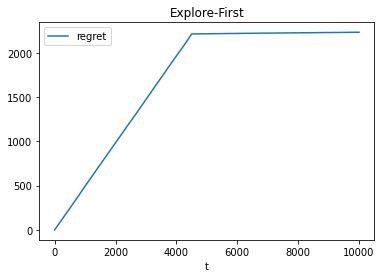

In [7]:
# DO NOT MODIFY
np.random.seed(SEED)
ef_df = run_repeated_experiments(ExploreFirst, SEED)
ef_df.plot(x='t', y='regret', title='Explore-First')

### Problem 2
(3 points) 

Implement the $ \epsilon_t $-*Greedy* algorithm (**Algorithm 1.2** in [Bandits]) within the provided bandit algorithm template below. Use $\epsilon_t = \min \left\{1,\ t^{-1/3} \cdot (K \log t)^{1/3}\right\} $.

In [8]:
class EpsilonTGreedy(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm
        
        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        self.t = 0
        #The probability with which we will explore instead of exploit
        self.epsilon = 1
        #The number of times we have selected each arm/action
        self.selected_actions = np.zeros(K)
        #The total accumulated reward for each arm/action
        self.total_rewards = np.zeros(K)
        #The mean reward for each arm/action
        self.mean_rewards = np.zeros(K)

    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        # FILL IN CODE HERE
        random_number = np.random.rand()
        if (random_number <= self.epsilon):
            return np.random.randint(0, self.K)
        return np.argmax(self.mean_rewards)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)
        """
        # FILL IN CODE HERE
        #this needs to be updated because it affects the epsilon value
        self.t += 1
        self.total_rewards[action] += reward
        self.selected_actions[action] += 1
        self.mean_rewards[action] = self.total_rewards[action] / self.selected_actions[action]
        self.epsilon = min(1, self.t**(-1/3)*(self.K*np.log(self.t))**(1/3))

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<AxesSubplot:title={'center':'Epsilon_t-Greedy'}, xlabel='t'>

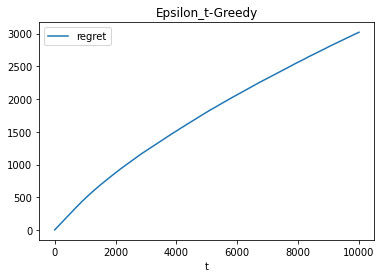

In [9]:
# DO NOT MODIFY
np.random.seed(SEED)
eg_df = run_repeated_experiments(EpsilonTGreedy, SEED)
eg_df.plot(x='t', y='regret', title='Epsilon_t-Greedy')

### Problem 3
(3 points) 

Implement the UCB1 algorithm (**Algorithm 1.5** in [Bandits]) within the provided bandit algorithm template below.

In [14]:
class UCB1(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        self.t = 0
        self.mean_rewards = np.zeros(K)
        self.total_rewards = np.zeros(K)
        self.selected_actions = np.zeros(K)
        self.ucb = np.zeros(K)
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step
        
        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        # FILL IN CODE HERE
        #Try each arm once
        if (self.t < self.K):
            return self.t
        return np.argmax(self.ucb)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)
        """
        # FILL IN CODE HERE
        self.t += 1
        self.selected_actions[action] += 1
        self.total_rewards[action] += reward
        self.mean_rewards[action] = self.total_rewards[action] / self.selected_actions[action]
        
        #the bug happens after i add the confidence radius
        confidence_radius = np.sqrt((2*np.log(self.T))/self.selected_actions[action])
        
        self.ucb[action] = self.mean_rewards[action] + confidence_radius

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<AxesSubplot:title={'center':'UCB1'}, xlabel='t'>

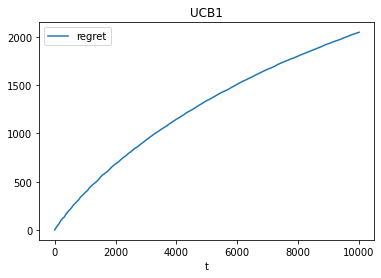

In [15]:
# DO NOT MODIFY
np.random.seed(SEED)
ucb1_df = run_repeated_experiments(UCB1, SEED)
ucb1_df.plot(x='t', y='regret', title='UCB1')

### Problem 4
(6 points) 

This theory problem is based on **Exercise 1.1** in [Bandits]. The proofs in **Chapter 1** consider environments where the rewards are in the interval $[0,1]$. Consider the case when we have additional knowledge about about the problem and that we know that the rewards for each action are in the interval $\left[\frac{1}{2}, \frac{1}{2} + \epsilon\right]$ for some fixed $\epsilon \in \left(0, \frac{1}{2}\right)$. 

Consider a version of $\text{UCB1}$ modified to utilize this knowledge (you do not need to specify the algorithm completely, just define the new confidence radius $r_t(a)$). For this algorithm and problem setting, prove that:

$\mathbb{E}\left[R(t)\right] \leq \frac{2 \epsilon t}{T^2} + 2 \epsilon \sqrt{2 K t \log T}$

**Instructions:** Use a version of Hoeffding Inequality with ranges (**Theorem A.2** in the [Bandits] book) to modify the confidence radius $r_t(a)$. Subsequently follow the steps of the analysis leading up to **Theorem 1.14** in [Bandits] to derive the regret bound, though show the actual constants instead of using big O notation:

1. Define the clean event, like in **Section 1.3.1**, and lower bound the probability of the event.
2. Start with the definition of the regret $\mathbb{E}\left[R(t)\right]$, and perform a regret decomposition like on **Page 11** of **Section 1.3.2**.
3. Bound the *gap* $\Delta (a_t)$, like in **Section 1.3.3**.
4. Complete the proof using the technique on **Page 12** of **Section 1.3.2**. Note that applying the bound in step 3 requires careful motivation.

*Write the solution in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### Solution

The new confidence radius will be 
$$\beta = \frac{1}{n} \sum_{i \in [n]} (b_i - a_i)^2 = \frac{1}{n} \sum_{i \in [n]} ((a_i + \epsilon) - a_i)^2 = \frac{1}{n} \sum_{i \in [n]} \epsilon^2 = \epsilon^2$$
$$
r(a) = \sqrt{\frac{\alpha \beta \log T}{n}}= \sqrt{\frac{2 \cdot \epsilon^2 \cdot \log T}{n}}
$$



The clean event happens if for all iterations of the UCB1 algorithm, the mean value deviates from the true expected value by at most the confidence radius. The probability of the clean event is:
$$\Pr\left(\left|\overline{u}_t(a) - u(a)\right| \leq r_a\right) \geq 1 - \frac{2}{T^{4}}$$
This must hold for all actions, for all time steps, so the clean event is defined as:
$$
\forall a, \forall t, \Pr\left(\left|\overline{u}_t(a) - u(a)\right| \leq r_a\right) \geq 1 - \frac{2}{T^2}
$$
We notice that the probability of the clean event for a single action for a single timestep was greater than or equal to $$1 - \frac{2}{T^{4}}$$ but for all actions and all time steps it was greater than or equal to $$1 - \frac{2}{T^2}$$.
The reason for this is because we have T time steps, and if the bad event happens at any of these time steps the clean event does not hold. The probability of bad event at any timestep is:
$$
\Pr\left( \left|\overline{u}_t(a) - u(a)\right| > r_a \right) \leq \frac{2}{T^4}
$$
For the bad event to hold on any of the T events, the probability becomes 
$$
\exists t \in \{1, 2, \dots, T\}, \Pr\left( \left|\overline{u}_t(a) - u(a)\right| > r_a \right) \leq \sum_{t=1}^{T} \frac{2}{T^4} \leq \frac{2}{T^3}
$$
For the bad event to hold on any of the actions for a specific timestep, we must assume we have K actions where $K<T$. So the probability becomes 
$$
\Pr\left( \exists a \in \{1, 2, \dots, K\}, \left|\overline{u}_t(a) - u(a)\right| > r_a \right) \leq \sum_{a=1}^{K} \frac{2}{T^4} \leq K \cdot \frac{2}{T^4} \leq \frac{2}{T^3}
$$
Hence, the probability of the bad event, i.e. that it holds for any action and for any timestep, is equal to:
$$
\Pr\left( \exists a \in \{1, 2, \dots, K\}, \exists t \in \{1, 2, \dots, T\}, \left|\overline{u}_t(a) - u(a)\right| > r_a \right) \leq \sum_{t=1}^{T} \sum_{a=1}^{K} \frac{2}{T^4} \leq K \cdot \frac{2}{T^3} \leq \frac{2}{T^2}
$$
Hence, the probability of the clean event which is equal to the complement of the bad event, is equal to
$$
\forall a, \forall t, \Pr\left(\left|\overline{u}_t(a) - u(a)\right| \leq r_a\right) \geq 1 - \frac{2}{T^2}
$$

The definition of Expected regret is 
$$
\mathbb{E}[R(t)] = \mathbb{E}[\text{Regret} \mid \text{Clean Event}] \cdot \Pr(\text{Clean Event}) + \mathbb{E}[\text{Regret} \mid \text{Bad Event}] \cdot \Pr(\text{Bad Event})
$$
We do not calculate the expected regret, but we upper bound it. We know the expected regret for the bad event can not be worse than $\epsilon \cdot t$ since the largest regret for a specific round(instant regret) is $\epsilon$. And the probability of the bad event is less than or equal to $\frac{2}{T^{2}}$. So we have that 
$$
\mathbb{E}[R(t)] = \mathbb{E}[\text{Regret} \mid \text{Clean Event}] \cdot \Pr(\text{Clean Event}) + \epsilon \cdot t \cdot \frac{2}{T^2}
$$
Now we need to upper bound the regret in the case of the clean event. We can do this as follows. 

We know that in the case of the clean event, if we select a suboptimal arm $a$ that has a lower expected reward than the optimal arm $a^*$, we can bound the regret. We have the following inequalities:

$$
\overline{u}_t(a) + 2r_t(a) \geq \overline{u}_t(a) + r_t(a) = \text{UCB}(a) \geq \text{UCB}(a^*) \geq \overline{u}_t(a^*)
$$

This gives us:

$$
\Delta a = u(a^*) - u(a) \leq 2r_t(a) = 2 \cdot \sqrt{\frac{2 \cdot \epsilon^2 \cdot \log T}{n_t(a)}}
$$


We can denote the accumulated regret for a specific action a, up to some round t, as $R(t,a)$. We have that 

$$
R(t,a) = n_t(a) \cdot \Delta a \leq n_t(a) \cdot 2r_t(a) = n_t(a) \cdot 2 \cdot \sqrt{\frac{2 \cdot \epsilon^2 \cdot \log T}{n_t(a)}} = 2 \cdot \sqrt{2 \cdot n_t(a) \cdot \epsilon^2 \cdot \log T} = 2\epsilon \cdot \sqrt{2 \cdot n_t(a) \cdot \log T}
$$

Now, we are interested in the total accumulated regret from all actions(that contribute to regret) up to round t. We denote this as $R(t)$. Let $A^+$ denote the set of all actions that contribute to regret. We have that 

$$
R(t) = \sum_{a \in A^+} R(t, a) \leq \sum_{a \in A^+} 2\epsilon \cdot \sqrt{2 \cdot n_t(a) \cdot \log T} = 2\epsilon \cdot \sum_{a \in A} \sqrt{2 \cdot \log T} \sqrt{n_t(a)} = 2\epsilon \cdot \sqrt{2 \cdot \log T} \cdot \sum_{a \in A} \sqrt{n_t(a)}
$$

Using the known fact that $\sum_{a \in A} n_t(a) = t$, we can use Jensen Inequality to state that:
$$
\frac{1}{K} \cdot \sum_{a \in A} \sqrt{n_t(a)} \leq \sqrt{\frac{1}{K} \cdot \sum_{a \in A} n_t(a)} = \sqrt{\frac{t}{K}} \implies \sum_{a \in A} \sqrt{n_t(a)} \leq \sqrt{t \cdot K} 
$$

This gives us that 
$$ 
R(t) \leq 2\epsilon \cdot \sqrt{2 \cdot \log T} \cdot \sum_{a \in A} \sqrt{n_t(a)} \leq 2 \epsilon \cdot \sqrt{2 \cdot t \cdot K \log T}
$$

So, we can then say that the expected regret in case the clean event holds for UC1 is equal to:

$$
\mathbb{E}[R(t) \mid \text{clean event}] \leq 2 \epsilon \cdot \sqrt{2 \cdot t \cdot K \log T}
$$

The probability of the clean event was very high and close to 1. We will use upper bound so we let it be equal to 1. We get that 

$$
\mathbb{E}[R(t)] = \mathbb{E}[\text{Regret} \mid \text{Clean Event}] \cdot \Pr(\text{Clean Event}) + \mathbb{E}[\text{Regret} \mid \text{Bad Event}] \cdot \Pr(\text{Bad Event}) \leq 2 \epsilon \cdot \sqrt{2 \cdot t \cdot K \log T} \cdot 1 + \epsilon \cdot t \cdot \frac{2}{T^2}
$$

Hence, we have that

$$
\mathbb{E}[R(t)] \leq 2 \epsilon \cdot \sqrt{2 \cdot t \cdot K \log T} + \frac{2 \cdot \epsilon \cdot t}{T^2}
$$

## Bayesian Bandits (Chapter 3)

### Problem 5
(3 points)

Implement the *Thompson Sampling* algorithm (**Algorithm 3.3** in [Bandits]) within the provided bandit algorithm template below. Assume independent priors and that the prior is $\mathbb{P} = \text{Beta}(\alpha_0, \beta_0)$ with $\alpha_0 = 1$ and $\beta_0 = 1$ (i.e. the **Beta-Bernoulli** setting, on **page 35** in [Bandits]).

**Note:** There is a typo in the expression for the posterior $\mathbb{P}_H$ in [Bandits]. It should be $\text{Beta}(\alpha_0 + \text{REW}_H,\ \beta_0 + t - \text{REW}_H)$.

In [18]:
class ThompsonSampling(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        self.t = np.zeros(K)
        self.rewards = np.zeros(K)
        self.alpha = np.ones(K)
        self.beta = np.ones(K)
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        # FILL IN CODE HERE
        samples = np.random.beta(self.alpha, self.beta)  # Sample from the Beta distributions
        return np.argmax(samples)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)
        """
        # FILL IN CODE HERE
        self.t[action] += 1
        self.rewards[action] += reward
        #update alpha
        self.alpha[action] = 1 + self.rewards[action]
        #update beta
        self.beta[action] = 1 + self.t[action] - self.rewards[action]

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<AxesSubplot:title={'center':'Thompson Sampling'}, xlabel='t'>

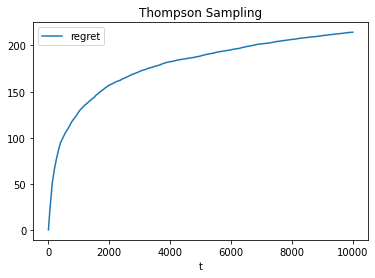

In [10]:
# DO NOT MODIFY
np.random.seed(SEED)
ts_df = run_repeated_experiments(ThompsonSampling, SEED)
ts_df.plot(x='t', y='regret', title='Thompson Sampling')

### Problem 6
(6 points)

In this theory problem, you will show an intermediary step in the proof for the Bayesian regret bound of *Thompson Sampling* in the [Bandits] book.

You are given a $K$-armed bandit problem with rewards in the interval $[0, 1]$. You can assume that $K \leq T$, where $T$ is the horizon. Additionally, you can assume that **Lemma 1.5** holds (i.e., for this assignment we define $r_t (a) := \sqrt{\frac{2  \log T}{ n_t (a)}}$, and then it holds that $\text{Pr}\left\{ \mathcal{E} \right\} \geq 1 - \frac{2}{T^2}$ with $\mathcal{E} := \left\{ \forall a \forall t \;\; \vert \bar{\mu}_t (a) - \mu (a) \vert \leq r_t (a) \right\}$). Then, with $\text{UCB}_t (a) := \bar{\mu}_t (a) + r_t (a)$, show that $\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] \leq \frac{2}{TK}$ (i.e., show that Equation 3.14 in [Bandits], with $\gamma = 2$, holds for all arms $a$ and rounds $t$).

**Note:** $[x]^{-}$ is the negative portion of $x$, i.e., $[x]^{-} = 0$ if $x \geq 0$ and $[x]^{-} = \vert x \vert$ otherwise.

**Hint:** Remember that, given a random variable $X$, an event $\mathcal{E}$ (subset of the sample space) and its complement $\mathcal{E}^c$, by the tower rule, $\mathbb{E}\left[ X \right] = \mathbb{E}\left[ X \;\vert\; \mathcal{E} \right] \cdot \text{Pr}\left\{ \mathcal{E} \right\} + \mathbb{E}\left[ X \;\vert\; \mathcal{E}^c \right] \cdot \text{Pr}\left\{ \mathcal{E}^c \right\}$.

*Write the solution in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### Solution

The formula $\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] \leq \frac{2}{TK}$ tells us the expected amount that the Upper confidence bound of action a underestimates the true mean of action a(in round t) **in those cases that it does so**. We know that it is uncommon for the upper confidence bound to underestimate the true expected mean. Why? Because the clean event happens with a probability of $\text{Pr}\left\{ \mathcal{E} \right\} \geq 1 - \frac{2}{T^2}$. The clean event simply means that the absolute difference between the true expected mean of an action and the current average reward of the action, for all actions and all rounds, is less than the confidence radius. If this is true, then we know the true mean is within the upper and lower confidence bounds. However, as mentioned the clean event does not always need to happen. The complement of the clean event $\mathcal{E}^c$ happens with probability $\text{Pr}\left\{ \mathcal{E}^c \right\} \leq \frac{2}{T^2}$. The complement of the clean event simply means that there is at least some action a in some round t whose average value deviates from its true mean more than the confidence radius. Hence, it could be either that the true mean is larger than the upper confidence bound $\text{UCB}_t (a)$ or that it is smaller than the lower confidence bound $\text{LCB}_t (a)$. Now, lets focus on why 
$$
\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] \leq \frac{2}{TK}
$$
is true. We can rewrite this using the **Tower Rule** as:
$$
\mathbb{E}\left[ \left( \text{UCB}_t(a) - \mu(a) \right)^{-} \right] = 0 \cdot P\left( \text{UCB}_t(a) \geq \mu(a) \right) + \mathbb{E}\left[ \mu(a) - \text{UCB}_t(a) \mid \text{UCB}_t(a) < \mu(a) \right] \cdot P\left( \text{UCB}_t(a) < \mu(a) \right) = \mathbb{E}\left[ \mu(a) - \text{UCB}_t(a) \mid \text{UCB}_t(a) < \mu(a) \right] \cdot P\left( \text{UCB}_t(a) < \mu(a) \right) 
$$

We also know that the largest difference between 2 rewards is 1 since all rewards are in the interval $[0,1]$. So we can say that 

$$
\mathbb{E}\left[ \mu(a) - \text{UCB}_t(a) \mid \text{UCB}_t(a) < \mu(a) \right] \cdot P\left( \text{UCB}_t(a) < \mu(a) \right) \leq 1 \cdot P\left( \text{UCB}_t(a) < \mu(a) \right)
$$

We also know the probability $P\left( \text{UCB}_t(a) < \mu(a) \right)$ is less than or equal to $\mathbf{\frac{2}{T^2}}$. The reason is that $\text{Pr}\left\{ \mathcal{E}^c \right\} \leq \frac{2}{T^2}$. The bad event happened if any action on any round had a true expected mean which was not within a confidence radius of its current mean reward. This would imply that $\text{UCB}_t(a) < \mu(a)$ or that $\text{LCB}_t(a) > \mu(a)$ and thus we have that 
$$
P\left( \text{UCB}_t(a) < \mu(a) \right) \leq \text{Pr}\left\{ \mathcal{E}^c \right\} \leq \frac{2}{T^2}
$$

Since $K \leq T$ we can write that 
$$
P\left( \text{UCB}_t(a) < \mu(a) \right) \leq \text{Pr}\left\{ \mathcal{E}^c \right\} \leq \frac{2}{T^2} \leq \frac{2}{TK}
$$

**Question1**: Is $P\left( \text{UCB}_t(a) < \mu(a) \right)$ bounded by $\mathbf{\frac{2}{T^2}}$ or $\mathbf{\frac{2}{T^4}}$? Why? Bandits-2 page 27. Ask on consultation.    
**Question2:** How does reward tape work? Why is it necessary to use reward tape?

## Final comparison

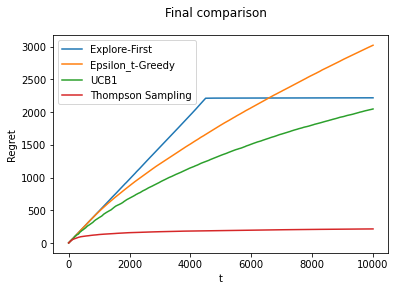

In [19]:
fig, ax = plt.subplots(1,1)
fig.suptitle("Final comparison")
ax.set_xlabel("t"); ax.set_ylabel("Regret")
dfs = [(ef_df, "Explore-First"), (eg_df, "Epsilon_t-Greedy"), (ucb1_df, "UCB1"), (ts_df, "Thompson Sampling")]
for df, label in dfs: df.plot(x='t', y='regret',ax = ax, label = label) 

## Bonus: KL-UCB 

(0 points)

As we explored in Problem 4, UCB1 relies on Hoeffding's inequality to determine the confidence radius. Hoeffding's inequality assumes that the reward is bounded (or more generally that they are sub-Gaussian). However, in this assignment we know that the rewards are Bernoulli distributed. As such, Hoeffding's inequality is too general to ensure optimal performance. 

KL-UCB is an upper confidence algorithm that uses the following selection rule (after sampling every arm once):
$$
a_t = \argmax_{a} \max_{\tilde{\mu}} \Big\{ \tilde \mu \in [0,1] : d(\bar{\mu}_t(a), \tilde \mu) \leq \frac{\log f(t)}{n_{t}(a)} \Big\}
$$
where $f(t) = 1 + t \log^2(t)$ and $d(p, q) = p \log \frac{p}{q} + (1-p) \log \frac{1-p}{1-q}$ is the KL-divergence between two Bernoulli distributions with mean $p \in (0,1)$ and $q \in (0,1)$. Note that $d(p,q)$ is undefined for $p$ or $q$ in $\{0,1\}$.

As a bonus exercise, implement KL-UCB and compare its performance against UCB1. Since KL-UCB relies on tighter concentration inequalities, we would expect KL-UCB to accumulate less regret than UCB1. 

If you are up for it, try making your implementation computationally efficient.

In [ ]:
class KLUCB(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        pass
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE
        pass
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        pass

In [ ]:
# DO NOT MODIFY
np.random.seed(SEED)
klucb_df = run_repeated_experiments(KLUCB, SEED)
klucb_df.plot(x='t', y='regret', title='KL-UCB')

In [ ]:
fig, ax = plt.subplots(1,1)
fig.suptitle("Final comparison")
ax.set_xlabel("t"); ax.set_ylabel("Regret")
dfs = [(ef_df, "Explore-First"), (eg_df, "Epsilon_t-Greedy"), (ucb1_df, "UCB1"), (ts_df, "Thompson Sampling"), (klucb_df, "KL-UCB")]
for df, label in dfs: df.plot(x='t', y='regret',ax = ax, label = label) 